In [588]:
%matplotlib widget
%config InlineBackend.figure_formats = ['png']
import glob
import sys
import csv
import json
import statistics
from datetime import datetime
from collections import defaultdict
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import scipy.stats as st
from matplotlib.transforms import Affine2D
from joblib import Parallel, delayed
from dateutil import parser

Declare global paths and variables

In [1008]:
OUTER_RUN = 50
PROTO = "svs"
OUTER_LOG_DIR = "/home/vpatil/milcom/logs/{}/{}".format(OUTER_RUN, PROTO)

PLATOONS = 4
NODES_PER_PLATOON = 5
SWITCH_TIME = 30
RUN_NUMBER = 0
NUM_ROUNDS = 2  # (while publishing)
SCHEME = "new"

NUM_RECVRS = (PLATOONS*NODES_PER_PLATOON-1) if SCHEME == "old" else ((PLATOONS-1)*NODES_PER_PLATOON-1)

COLORS = ["blue", "orange", "red", "green"]
MARKERS = ["^", "o", "^", "o"]

Process all log files

In [1010]:
def plot_delivery(ax, outer_run, proto, label=None):
    outer_log_dir = "/home/vpatil/milcom/logs/{}/{}".format(outer_run, proto)

    time_vals = np.arange(0, 4.5*4*SWITCH_TIME, 0.5)
    num_pubs = np.zeros_like(time_vals)
    num_recv = np.zeros_like(time_vals)

    ref_ts = None

    def parse_logfile(codename):
        nonlocal ref_ts
        fname = outer_log_dir + '/{}/{}.log'.format(RUN_NUMBER, codename)
        print('Processing', fname)

        with open(fname) as f:
            if proto == "ip":
                reader = []
                for line in f:
                    pcs = line.split()
                    reader.append({
                        "t": pcs[0].split('"')[1::2][0],
                        "m": pcs[2].split('"')[1::2][0]
                    })
            else:
                reader = csv.DictReader(f, fieldnames=['t', 'pid', 'tid', 'm'],
                                        quotechar='"', delimiter=',', quoting=csv.QUOTE_ALL,
                                        skipinitialspace=True)
        
            for row in reader:
                timestamp = round(parser.parse(row['t']).timestamp() * 1000)
                if not ref_ts:
                    ref_ts = timestamp
                t = (timestamp - ref_ts) / 1000

                pub_msg = "PUBL_MSG::/pos"
                recv_msg = "RECV_MSG::/pos"
                if proto == "ip":
                    pub_msg = "PUBL_MSG"
                    recv_msg = "RECV_MSG"

                if pub_msg in row['m']:
                    for i in range(round(t * 2), len(num_pubs)):
                        num_pubs[i] += 1

                if recv_msg in row['m']:
                    for i in range(round(t * 2), len(num_recv)):
                        num_recv[i] += 1

    for p in range(0, PLATOONS):
        for u in range(0, NODES_PER_PLATOON):
            parse_logfile('unit_{}_{}'.format(p, u))

    print((num_recv/(PLATOONS*NODES_PER_PLATOON-1)/num_pubs)[-1])
    
    x, y = time_vals+(2 if proto == 'ip' else 1), num_recv/NUM_RECVRS/num_pubs

    ax.plot(x, y, label=label)
    ax.axvline(x=SWITCH_TIME*PLATOONS*NUM_ROUNDS, color='gray', linestyle=':')
    #ax.set_xticks(np.append(ax.get_xticks(), SWITCH_TIME*PLATOONS*NUM_ROUNDS))
    ax.set_xticks(np.arange(0, SWITCH_TIME*PLATOONS*(NUM_ROUNDS + 3), SWITCH_TIME*2))
    ax.set_xlim(0, SWITCH_TIME*PLATOONS*(NUM_ROUNDS+2))

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Processing /home/vpatil/milcom/logs/50/svs/0/unit_0_0.log
Processing /home/vpatil/milcom/logs/50/svs/0/unit_0_1.log
Processing /home/vpatil/milcom/logs/50/svs/0/unit_0_2.log
Processing /home/vpatil/milcom/logs/50/svs/0/unit_0_3.log
Processing /home/vpatil/milcom/logs/50/svs/0/unit_0_4.log
Processing /home/vpatil/milcom/logs/50/svs/0/unit_1_0.log
Processing /home/vpatil/milcom/logs/50/svs/0/unit_1_1.log
Processing /home/vpatil/milcom/logs/50/svs/0/unit_1_2.log
Processing /home/vpatil/milcom/logs/50/svs/0/unit_1_3.log
Processing /home/vpatil/milcom/logs/50/svs/0/unit_1_4.log
Processing /home/vpatil/milcom/logs/50/svs/0/unit_2_0.log
Processing /home/vpatil/milcom/logs/50/svs/0/unit_2_1.log
Processing /home/vpatil/milcom/logs/50/svs/0/unit_2_2.log
Processing /home/vpatil/milcom/logs/50/svs/0/unit_2_3.log
Processing /home/vpatil/milcom/logs/50/svs/0/unit_2_4.log
Processing /home/vpatil/milcom/logs/50/svs/0/unit_3_0.log
Processing /home/vpatil/milcom/logs/50/svs/0/unit_3_1.log
Processing /ho

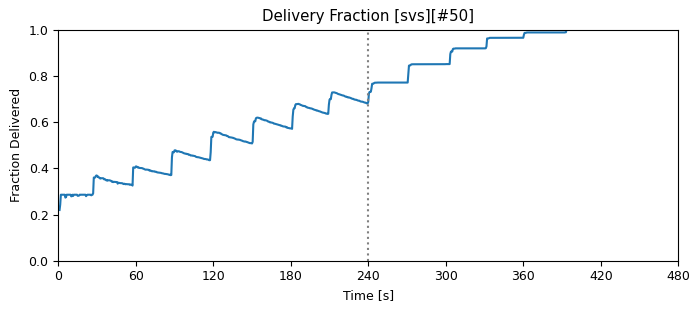

In [1009]:
fig, ax = plt.subplots()
fig.set_size_inches(8, 3)
ax.set_title("Delivery Fraction [{}][#{}]".format(PROTO, OUTER_RUN))
ax.set_ylabel('Fraction Delivered')
ax.set_xlabel('Time [s]')
ax.set_ylim(0, 1)

plot_delivery(ax, OUTER_RUN, PROTO)

display(fig)
plt.close()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

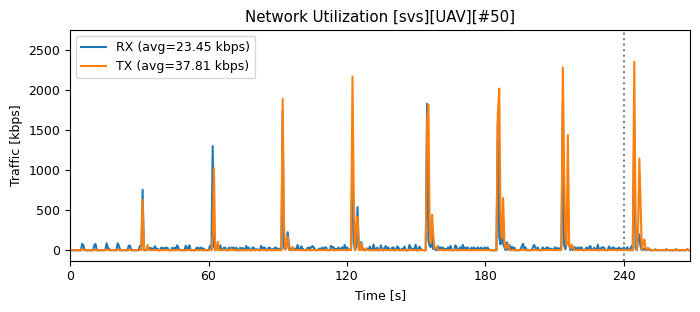

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

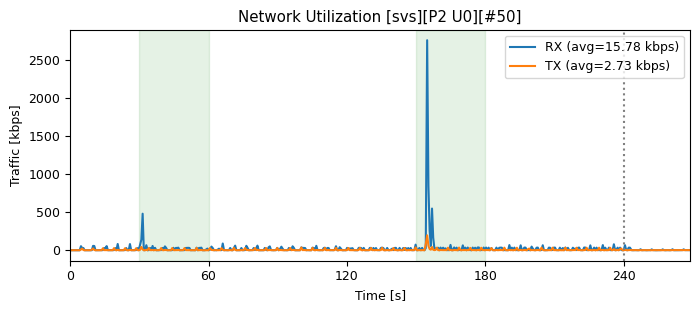

In [1011]:
def parse_ifconfig_file(filename):
    data = {}
    with open(filename) as f:
        curr_timestamp = 0
        iface = None
        for line in f:
            line = line.strip()

            if line.startswith('EVAL_TIME=='):
                curr_timestamp = int(round(float(line.split('==')[1])))
                iface = None
                data[curr_timestamp] = {}
                continue

            if 'RUNNING' in line:
                iface = line.split(':')[0]
                if iface == 'lo':
                    iface = None
                    continue

                data[curr_timestamp][iface] = {}
                continue

            if not iface:
                continue

            if 'RX packets' in line:
                data[curr_timestamp][iface]['rx_packets'] = round(float(line.split()[2]))
                data[curr_timestamp][iface]['rx_bytes'] = round(float(line.split()[4]))

            if 'TX packets' in line:
                data[curr_timestamp][iface]['tx_packets'] = round(float(line.split()[2]))
                data[curr_timestamp][iface]['tx_bytes'] = round(float(line.split()[4]))

    aggr_rx_bytes = defaultdict(int)
    aggr_tx_bytes = defaultdict(int)

    for timestamp in data:
        tdata = data[timestamp]
        for iface in tdata:
            aggr_rx_bytes[timestamp] += tdata[iface]['rx_bytes']
            aggr_tx_bytes[timestamp] += tdata[iface]['tx_bytes']

    return data, aggr_rx_bytes, aggr_tx_bytes

def aggr_to_xy(aggr):
    keys, values = zip(*aggr.items())
    keys = np.array(keys)
    keys = keys - keys[0] + 500
    
    speed = np.zeros(len(values))
    for i, key in enumerate(keys):
        if i == 0:
            continue
        diff = values[i] - values[i - 1]
        speed[i] = diff / ((keys[i] - keys[i-1]) / 1000)
    return keys / 1000, speed

def plot_traffic(ax, codename, humanname, outer_run, proto):
    outer_log_dir = "/home/vpatil/milcom/logs/{}/{}".format(outer_run, proto)

    _, aggr_rx_bytes, aggr_tx_bytes = parse_ifconfig_file(
        outer_log_dir + '/{}/report-eval-{}.ifconfig'.format(0, codename))
    
    def avgv(x, y):
        return round(np.sum(y * 8 / 1000) / x[-1], 2)
    
    def avgv1(agg, x):
        return round((agg[max(agg.keys())] / x[-1]) * 8 / 1000, 2)

    x, y = aggr_to_xy(aggr_rx_bytes)

    #ax.plot(x, y * 8 / 1000, label="RX (avg={} kbps)".format(avgv(x,y)))
    ax.plot(x, y * 8 / 1000, label="RX (avg={} kbps)".format(avgv1(aggr_rx_bytes, x)))
    x, y = aggr_to_xy(aggr_tx_bytes)
    ax.plot(x, y * 8 / 1000, label="TX (avg={} kbps)".format(avgv1(aggr_tx_bytes, x)))
    ax.axvline(x=SWITCH_TIME*PLATOONS*NUM_ROUNDS, color='gray', linestyle=':')
    # ax.set_xticks(np.append(ax.get_xticks(), SWITCH_TIME*PLATOONS*3))
    ax.set_xticks(np.arange(0, SWITCH_TIME*PLATOONS*(NUM_ROUNDS + 3), SWITCH_TIME * 2))
    ax.set_xlim(0, SWITCH_TIME*PLATOONS*(NUM_ROUNDS + 0.24))
    
    platoon = ''
    if 'ap' in codename:
        platoon = codename[-1]
    elif 'unit' in codename:
        platoon = codename.split('_')[1]
    if platoon:
        platoon = int(platoon)

        for i in range(0, NUM_ROUNDS + 3):
            ax.axvspan((platoon+i*PLATOONS-1)*SWITCH_TIME, (platoon+i*PLATOONS)*SWITCH_TIME, alpha=0.1, color='green')

def plot_utilization(codename, humanname):
    fig, ax = plt.subplots()
    fig.set_size_inches(8, 3)
    ax.set_title('Network Utilization [{}][{}][#{}]'.format(PROTO, humanname, OUTER_RUN))
    ax.set_ylabel('Traffic [kbps]')
    ax.set_xlabel('Time [s]')
    
    plot_traffic(ax, codename, humanname, OUTER_RUN, PROTO)
    
    ax.legend()

    display(fig)
    plt.close()

plot_utilization('uav', 'UAV')
# if PROTO != "ip":
    # plot_utilization('ap1', 'AP1')
plot_utilization('unit_2_0', 'P2 U0')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

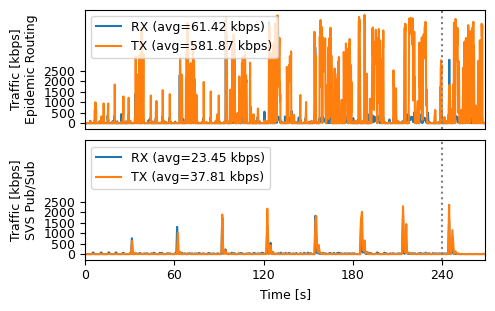

In [1060]:
# Traffic comparison plot ER vs SVS
plt.rcParams.update({'font.size': 9})

twocols = 0
if twocols:
    fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
    fig.set_size_inches(4, 2)
else:
    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, sharey=True)
    fig.set_size_inches(4, 2.5)

ax1.set_ylabel('Traffic [kbps]')
if not twocols:
    ax1.set_ylabel('Traffic [kbps]\nEpidemic Routing')
    ax2.set_ylabel('Traffic [kbps]\nSVS Pub/Sub')
    

#plot_traffic(ax1, 'unit_2_0', 'P2 U0', 24, "ip")
#plot_traffic(ax2, 'unit_2_0', 'P2 U0', 21, "svs")

# new
#plot_traffic(ax1, 'unit_2_0', 'P2 U0', 43, "ip")
#plot_traffic(ax2, 'unit_2_0', 'P2 U0', 38, "svs")
# new 5nodes (44)
#plot_traffic(ax1, 'unit_2_0', 'P2 U0', 49, "ip")
#plot_traffic(ax2, 'unit_2_0', 'P2 U0', 50, "svs")
plot_traffic(ax1, 'uav', 'P2 U0', 49, "ip")
plot_traffic(ax2, 'uav', 'P2 U0', 50, "svs")
ax1.set_yticks(np.arange(0, 2501, 500))
#ax1.set_ylim(0, 550)


# wifi
#plot_traffic(ax1, 'unit_2_0', 'P2 U0', 42, "ip")
#plot_traffic(ax2, 'unit_2_0', 'P2 U0', 42, "svs")
#ax1.set_yticks(np.arange(0, 3001, 500))
#ax1.set_ylim(0)

if twocols:
    ax2.tick_params(labelleft=False, left=False)
    plt.subplots_adjust(left=0,
                        bottom=0, 
                        right=1, 
                        top=1, 
                        wspace=0.02, 
                        hspace=0.4)
else:
    ax1.tick_params(labelbottom=False, bottom=False)
    plt.subplots_adjust(left=0,
                        bottom=0, 
                        right=1, 
                        top=1, 
                        wspace=0.02, 
                        hspace=0.10)
    
if twocols:
    plt.text(0.5, -0.28, "Time [s]", fontsize=9, transform=plt.gcf().transFigure, ha='center', va='center')
    plt.text(0.75, -0.18, "SVS Pub/Sub", fontsize=9, transform=plt.gcf().transFigure, ha='center', va='center')
    plt.text(0.25, -0.18, "Epidemic Routing", fontsize=9, transform=plt.gcf().transFigure, ha='center', va='center')
else:
    plt.text(0.5, -0.14, "Time [s]", fontsize=9, transform=plt.gcf().transFigure, ha='center', va='center')
    #plt.text(0.5, -0.13, "SVS Pub/Sub", fontsize=9, transform=plt.gcf().transFigure, ha='center', va='center')
    #plt.text(0.5, 0.50, "Epidemic Routing", fontsize=9, transform=plt.gcf().transFigure, ha='center', va='center')
    
ax1.legend(loc='upper left')
ax2.legend(loc='upper left')

fig.savefig("traffic_comp.pdf", bbox_inches='tight', pad_inches = 0)

display(fig)
plt.close()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Processing /home/vpatil/milcom/logs/49/ip/0/unit_0_0.log
Processing /home/vpatil/milcom/logs/49/ip/0/unit_0_1.log
Processing /home/vpatil/milcom/logs/49/ip/0/unit_0_2.log
Processing /home/vpatil/milcom/logs/49/ip/0/unit_0_3.log
Processing /home/vpatil/milcom/logs/49/ip/0/unit_0_4.log
Processing /home/vpatil/milcom/logs/49/ip/0/unit_1_0.log
Processing /home/vpatil/milcom/logs/49/ip/0/unit_1_1.log
Processing /home/vpatil/milcom/logs/49/ip/0/unit_1_2.log
Processing /home/vpatil/milcom/logs/49/ip/0/unit_1_3.log
Processing /home/vpatil/milcom/logs/49/ip/0/unit_1_4.log
Processing /home/vpatil/milcom/logs/49/ip/0/unit_2_0.log
Processing /home/vpatil/milcom/logs/49/ip/0/unit_2_1.log
Processing /home/vpatil/milcom/logs/49/ip/0/unit_2_2.log
Processing /home/vpatil/milcom/logs/49/ip/0/unit_2_3.log
Processing /home/vpatil/milcom/logs/49/ip/0/unit_2_4.log
Processing /home/vpatil/milcom/logs/49/ip/0/unit_3_0.log
Processing /home/vpatil/milcom/logs/49/ip/0/unit_3_1.log
Processing /home/vpatil/milcom/

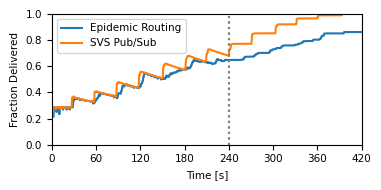

In [1023]:
#Delivery comparison
plt.rcParams.update({'font.size': 7.5})
fig, ax = plt.subplots()
fig.set_size_inches(4, 1.7)
ax.set_ylabel('Fraction Delivered')
ax.set_xlabel('Time [s]')
ax.set_ylim(0, 1)

#old
#plot_delivery(ax, 24, "ip", label="Epidemic Routing")
#plot_delivery(ax, 21, "svs", label="SVS Pub/Sub")

#3nodenew
#plot_delivery(ax, 43, "ip", label="Epidemic Routing")
#plot_delivery(ax, 38, "svs", label="SVS Pub/Sub")
#5nodenew (44)
plot_delivery(ax, 49, "ip", label="Epidemic Routing")
plot_delivery(ax, 50, "svs", label="SVS Pub/Sub")
ax.set_xlim(0, 420)

#wifi
#plot_delivery(ax, 42, "ip", label="Epidemic Routing")
#plot_delivery(ax, 42, "svs", label="SVS Pub/Sub")

#ax.set_xlim(0, 210)
ax.legend()

fig.savefig("delivery.pdf", bbox_inches='tight', pad_inches = 0)

display(fig)
plt.close()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

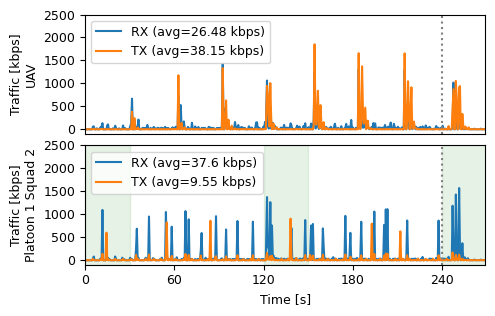

In [1059]:
# Traffic comparison plot
plt.rcParams.update({'font.size': 9})

twocols = 0
if twocols:
    fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
    fig.set_size_inches(4, 2)
else:
    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, sharey=True)
    fig.set_size_inches(4, 2.5)

ax1.set_ylabel('Traffic [kbps]')
if not twocols:
    ax1.set_ylabel('Traffic [kbps]\nUAV')
    ax2.set_ylabel('Traffic [kbps]\nPlatoon 1 Squad 2')

#oldid 25
plot_traffic(ax1, 'uav', 'UAV', 52, "svs")
plot_traffic(ax2, 'unit_1_2', 'P1 U2', 52, "svs")

if twocols:
    ax2.tick_params(labelleft=False, left=False)
    plt.subplots_adjust(left=0,
                        bottom=0, 
                        right=1, 
                        top=1, 
                        wspace=0.02, 
                        hspace=0.4)
else:
    ax1.tick_params(labelbottom=False, bottom=False)
    plt.subplots_adjust(left=0,
                        bottom=0, 
                        right=1, 
                        top=1, 
                        wspace=0.02, 
                        hspace=0.10)
    ax1.set_yticks(np.arange(0, 2510, 500))


if twocols:
    plt.text(0.5, -0.28, "Time [s]", fontsize=9, transform=plt.gcf().transFigure, ha='center', va='center')
    plt.text(0.75, -0.18, "SVS Pub/Sub", fontsize=9, transform=plt.gcf().transFigure, ha='center', va='center')
    plt.text(0.25, -0.18, "Epidemic Routing", fontsize=9, transform=plt.gcf().transFigure, ha='center', va='center')
else:
    plt.text(0.5, -0.14, "Time [s]", fontsize=9, transform=plt.gcf().transFigure, ha='center', va='center')
    
ax1.legend(loc='upper left')
ax2.legend(loc='upper left')

fig.savefig("traffic_svs.pdf", bbox_inches='tight', pad_inches=0)

display(fig)
plt.close()